In [1]:
root_path = '/mnt/storage/fangyijie/fetal_us_planes/'
model_dir = '/mnt/storage/fangyijie/fetal_us_planes/0310_saved_models/'
# spain_train_1150_balanced.csv
# spain_train_5500_random_select.csv
all_sp_train = 'all_train_no_cer.csv'
sp_train_file = 'spain_train_1150_balanced.csv'
syn_train_file = 'synthetic_train_5000.csv'
af_train_file = 'African_train.csv'
ot_train_file = 'spain_other_train.csv'
test_file = 'African_test.csv'

### Load Target Labels

In [2]:
import pandas as pd

In [3]:
AF_TRAIN = False
HAS_AF = False
HAS_OTHER = False
ALL_TRAIN = True

In [4]:
if AF_TRAIN:
    train_df = pd.read_csv(root_path + af_train_file, sep=',')
    train_df = train_df.iloc[:,[1,4]]
elif ALL_TRAIN:
    train_df = pd.read_csv(root_path + all_sp_train, sep=',')
    train_df = train_df.iloc[:,[0,2]]
else:
    train_df = pd.read_csv(root_path + sp_train_file, sep=',')
    train_df = train_df.iloc[:,[2,3]]
train_df.head(3)

,Image_name,Plane
0,Patient00001_Plane1_1_of_15,Other
1,Patient00001_Plane1_2_of_15,Other
2,Patient00001_Plane1_3_of_15,Other


In [5]:
if HAS_OTHER:
    ot_train_df = pd.read_csv(root_path + ot_train_file, sep=',')
    print(ot_train_df.shape)

In [6]:
if HAS_AF:
    af_train_df = pd.read_csv(root_path + af_train_file, sep=',')
    af_train_df = af_train_df.iloc[:,[1,4]]
    print(af_train_df.shape)

In [7]:
syn_train_df = pd.read_csv(root_path + syn_train_file, sep=',')
syn_train_df.head(3)

,Image_name,Plane,Train
0,00000-2671683618,Fetal abdomen,1
1,00001-2671683619,Fetal abdomen,1
2,00002-2671683620,Fetal abdomen,1


In [8]:
test_df = pd.read_csv(root_path + test_file, sep=',')
test_df.head(3)

,Patient_num,Plane,Train,Center,Image_name
0,1,Fetal abdomen,0,Algeria,patient001_DZA_plane0
1,1,Fetal femur,0,Algeria,patient001_DZA_plane2
2,1,Fetal brain,0,Algeria,patient001_DZA_plane1


In [9]:
train_df.shape

(6148, 2)

In [10]:
syn_train_df = syn_train_df.iloc[:,[0,1]]
syn_train_df.shape

(5000, 2)

In [11]:
test_df = test_df.iloc[:,[4,1]]
test_df.shape

(233, 2)

In [12]:
print(test_df["Plane"].unique())

['Fetal abdomen' 'Fetal femur' 'Fetal brain' 'Fetal thorax']


In [13]:
class2idx = {
    "Other":0,
    "Fetal abdomen":1,
    "Fetal brain":2,
    # "Maternal cervix":3,
    "Fetal femur":4,
    "Fetal thorax":5
}

In [14]:
idx2class = {v: k for k, v in class2idx.items()}

In [15]:
train_df["Plane"].replace(class2idx, inplace=True)
syn_train_df["Plane"].replace(class2idx, inplace=True)
test_df["Plane"].replace(class2idx, inplace=True)

if HAS_OTHER:
    ot_train_df["Plane"].replace(class2idx, inplace=True)

if HAS_AF:
    af_train_df["Plane"].replace(class2idx, inplace=True)

In [16]:
train_df.head(3)

,Image_name,Plane
0,Patient00001_Plane1_1_of_15,0
1,Patient00001_Plane1_2_of_15,0
2,Patient00001_Plane1_3_of_15,0


In [17]:
syn_train_df.head(3)

,Image_name,Plane
0,00000-2671683618,1
1,00001-2671683619,1
2,00002-2671683620,1


In [18]:
if HAS_OTHER:
    print(ot_train_df.head(3))

In [19]:
if HAS_AF:
    print(af_train_df.head(3))

In [20]:
test_df.head(3)

,Image_name,Plane
0,patient001_DZA_plane0,1
1,patient001_DZA_plane2,4
2,patient001_DZA_plane1,2


### Build Data Loader

In [21]:
import sys
import torch
import os
import glob
import PIL.Image
import torch.utils.data
import subprocess
import cv2
import numpy as np
import matplotlib.image as img

In [22]:
COMMON_TR = True

In [23]:
import torchvision.transforms as transforms
import torch.nn.functional as F

torch.manual_seed(0)

if COMMON_TR:
    TRANSFORMS = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ])
else:
    TRANSFORMS = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ])

VAL_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
])

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, df, train=False, is_af=False, is_synthetic=False, transform=None, random_hflip=False):
        super(Dataset, self).__init__()
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.random_hflip = random_hflip
        if self.train == True and is_af:
            self.folder_path = self.root_dir + 'african_cnn_train/'
        elif self.train == True and is_synthetic:
            self.folder_path = self.root_dir + 'synthetic_train_5000/'
        elif self.train == True:
            self.folder_path = self.root_dir + 'Planes_Train/'
        else:
            self.folder_path = self.root_dir + 'african_cnn_test/'

        self.records = df
        self.paths = [self.folder_path + filename + '.png' for filename in self.records['Image_name'].tolist()]
        self.labels = pd.get_dummies(self.records['Plane'].tolist())

        if self.labels.shape[1] == 4:
            self.labels.insert(0, 0, False)
        
        if self.labels.shape[1] == 1:
            self.labels.insert(1, 1, False)
            self.labels.insert(2, 2, False)
            self.labels.insert(3, 4, False)
            self.labels.insert(4, 5, False)

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image = cv2.imread(self.paths[index], cv2.IMREAD_COLOR) #load US images
        image = PIL.Image.fromarray(image)
        #image = PIL.Image.open(self.paths[index]).convert('RGB')
        #image = img.imread(self.paths[index])
        label = self.labels.iloc[index].tolist() #get label of ultrasound image
        label = torch.Tensor(label) #convert type from numpy to torch

        if self.transform is not None:
            image = self.transform(image)

        #if self.random_hflip and float(np.random.random(1)) > 0.5:
        #    image = torch.from_numpy(image.numpy()[..., ::-1].copy())

        image = torch.from_numpy(image.numpy()[..., ::])

        return image, label

### Build Pre-Trained Model


In [25]:
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [27]:
orig_img = Image.open(root_path + 'Planes_Train/Patient00807_Plane3_3_of_5.png')

In [29]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

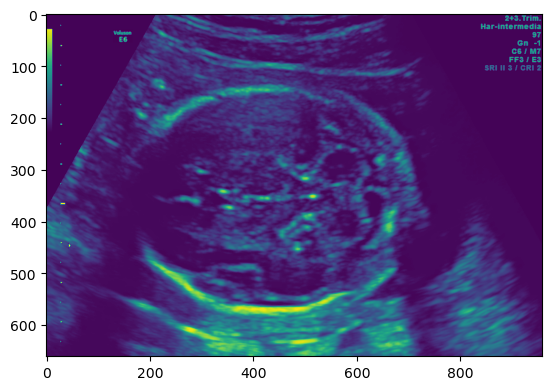

In [46]:
plt.imshow(orig_img)

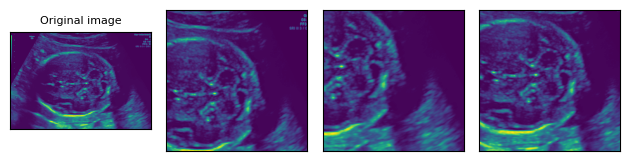

In [30]:
resize_cropper = transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0))
resized_crops = [resize_cropper(orig_img) for _ in range(3)]
plot(resized_crops)

In [26]:
import torch
import torchvision
from torchvision.models import DenseNet169_Weights, ResNet18_Weights, MobileNet_V2_Weights, EfficientNet_B0_Weights, ViT_B_16_Weights

#device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
output_dim = len(class2idx)  # 5 categories for classification

# RESNET 18
# m_name = 'resnet'
# model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# num_features = model.fc.in_features
# model.fc = torch.nn.Linear(num_features, output_dim)

# MOBILENET V2
# m_name = 'mobilenet'
# model = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
# num_features = model.classifier[1].in_features
# model.classifier[1] = torch.nn.Linear(num_features, output_dim)

# EfficientNet B0
# m_name = 'efficientnet'
# model = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# num_features = model.classifier[1].in_features
# model.classifier[1] = torch.nn.Linear(num_features, output_dim)

# DENSENET 169
# m_name = 'densenet'
# model = torchvision.models.densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)
# num_features = model.classifier.in_features
# model.classifier = torch.nn.Linear(num_features, output_dim)

# ViT B16
m_name = 'vit'
model = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
num_features = model.heads[0].in_features
model.heads[0] = torch.nn.Linear(num_features, output_dim)

model = model.to(device)


In [32]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Train the Model

In [27]:
BATCH_SIZE = 24  # 64 could cause "out of memory error"
lr = 1e-3  # learning rate
num_epochs = 20  # number of epochs

criterion = torch.nn.CrossEntropyLoss()

sm = torch.nn.Softmax()

#optimizer = torch.optim.Adam(model.parameters(), lr= lr, weight_decay=0.9) #define the optimiser as Adam
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [34]:
train_dataset = Dataset(root_dir=root_path, 
                        df=train_df, 
                        train=True, 
                        is_af=False,
                        is_synthetic=False,
                        transform=TRANSFORMS, 
                        random_hflip=True)

In [35]:
HYBRID = True

In [36]:
if HYBRID:
    from torch.utils.data import ConcatDataset
    syn_train_dataset = Dataset(root_dir=root_path, 
                        df=syn_train_df, 
                        train=True, 
                        is_synthetic=True,
                        transform=TRANSFORMS, 
                        random_hflip=True)
    train_dataset = ConcatDataset([train_dataset, syn_train_dataset])

In [37]:
if HAS_OTHER:
    from torch.utils.data import ConcatDataset

    ot_train_dataset = Dataset(root_dir=root_path, 
                        df=ot_train_df, 
                        train=True, 
                        is_af=False,
                        is_synthetic=False,
                        transform=TRANSFORMS, 
                        random_hflip=True)
    train_dataset = ConcatDataset([train_dataset, ot_train_dataset])

In [38]:
if HAS_AF:
    from torch.utils.data import ConcatDataset

    af_train_dataset = Dataset(root_dir=root_path, 
                        df=af_train_df, 
                        train=True, 
                        is_af=True,
                        is_synthetic=False,
                        transform=TRANSFORMS, 
                        random_hflip=True)
    train_dataset = ConcatDataset([train_dataset, af_train_dataset])

In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=0, drop_last=False)

In [40]:
num_samples = 200
random_sampler = torch.utils.data.RandomSampler(train_dataset, num_samples=num_samples)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=random_sampler)

In [28]:
test_dataset = Dataset(root_dir=root_path, df=test_df, 
                       train=False, transform=VAL_TRANSFORMS, 
                       random_hflip=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                          shuffle=True, num_workers=0, drop_last=False)

In [42]:
print(f'training data size: {len(train_dataset)}')
print(f'test data size: {len(test_dataset)}')

training data size: 11148
test data size: 233


### Start Training

In [43]:
train_loss = []
train_auc = []

val_loss = []
val_auc = []

total_tr_step = len(train_loader)
total_val_step = len(val_loader)

best_val_auc = 0.0

early_trigger = 5 #if the validation AUC hasn't increased in ten epochs, stop the training
early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC


In [44]:
for epoch in range(1, num_epochs+1):
    i = 0
    sum_loss = 0.0
    error_count = 0.0
    running_loss = 0.0
    train_correct = 0
    train_total=0

    #with tqdm(train_loader, unit="batch") as tepoch:
    model.train()
    for image, target in iter(tqdm(train_loader)):
      image = image.to(device)
      target = target.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()

      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(image)
      # probablities for classes
      #probs = sm(output)
      # get the predicted label
      #_,pred = torch.max(output, dim=1)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss wrt model parameters
      loss.backward()
      # perform a ingle optimization step (parameter update)
      optimizer.step()
      # update training loss
      running_loss += loss.item()

      pred_softmax = torch.log_softmax(output, dim = 1)
      _,pred = torch.max(pred_softmax, dim=1)
      #target_label = np.argmax(target, axis=1)      # for CPU
      target_label = target.argmax(1).cpu().numpy()  # for GPU

      target_label = torch.from_numpy(target_label).to(device)             # for GPU ONLY
      train_correct += torch.sum(pred == target_label).item()
      train_total += target_label.size(0)

      train_auc.append(100 * train_correct / train_total)
      train_loss.append(running_loss/total_tr_step)

    # print("epoch : {0} | train loss : {1} | train auc : {2} ".format(epoch, np.mean(train_loss), np.mean(train_auc)))
    # print('-' * 50)

    sum_loss = 0.0
    error_count = 0.0
    running_loss = 0.0
    val_correct = 0
    val_total=0
    targets = []
    preds = []

    model.eval()
    # with tqdm(test_loader, unit="batch") as tepoch:
    for image, target in iter(tqdm(val_loader)):
      image = image.to(device)
      target = target.to(device)
      output = model(image)
      loss = criterion(output, target)
      running_loss += loss.item()
      pred_softmax = torch.log_softmax(output, dim = 1)
      _,pred = torch.max(pred_softmax, dim=1)

      target_label = target.argmax(1).cpu().numpy()  # for GPU
      target_label = torch.from_numpy(target_label).to(device)  # for GPU ONLY

      targets = targets + list(target_label.cpu().numpy())  # for GPU ONLY
      preds = preds + list(pred.cpu().numpy())  # for GPU ONLY

      val_correct += torch.sum(pred == target_label).item()
      val_total += target_label.size(0)

      val_auc.append(100 * val_correct / val_total)
      val_loss.append(running_loss/total_val_step)

      # if val_auc[-1] > best_val_auc:
      #   best_val_auc = val_auc[-1]
      #   early_stop = 0
      # else:
      #   early_stop += 1

      # if early_stop == early_trigger:
      #   print('Early stopping after {} epochs'.format(epoch))
      #   sys.exit()

    print("epoch : {0} | train loss : {1} | train auc : {2} | val loss : {3} | val auc : {4} ".format(epoch,
                                                                                                      np.mean(train_loss),
                                                                                                      np.mean(train_auc),
                                                                                                      np.mean(val_loss),
                                                                                                      np.mean(val_auc)))
    print('-' * 50)

100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


epoch : 1 | train loss : 0.2433780880333723 | train auc : 76.84910757022729 | val loss : 0.1426134615400691 | val auc : 90.22134038800705 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


epoch : 2 | train loss : 0.17799612933746134 | train auc : 84.57951716984589 | val loss : 0.1136598836308644 | val auc : 91.5162037037037 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


epoch : 3 | train loss : 0.1508205572410645 | train auc : 87.5566439279754 | val loss : 0.11045174000194534 | val auc : 91.71814373897706 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


epoch : 4 | train loss : 0.13308787323357893 | train auc : 89.24998925777183 | val loss : 0.10970930113560623 | val auc : 92.12378747795415 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


epoch : 5 | train loss : 0.12173681831488906 | train auc : 90.34621525185676 | val loss : 0.10921891004215052 | val auc : 92.54951499118167 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


epoch : 6 | train loss : 0.11380546575758417 | train auc : 91.07708749221 | val loss : 0.09874526633969181 | val auc : 93.47556584362142 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


epoch : 7 | train loss : 0.10753126645798133 | train auc : 91.67149244299807 | val loss : 0.09358016640765879 | val auc : 93.8494740488788 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


epoch : 8 | train loss : 0.1024101870947143 | train auc : 92.11339867316876 | val loss : 0.08875188464945596 | val auc : 94.25168099647266 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


epoch : 9 | train loss : 0.09842707090544722 | train auc : 92.43563966981802 | val loss : 0.08519430328620436 | val auc : 94.58254948069764 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


epoch : 10 | train loss : 0.09483255361559988 | train auc : 92.76276970672136 | val loss : 0.08018770415312897 | val auc : 94.90457451499118 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


epoch : 11 | train loss : 0.09144607486283006 | train auc : 93.04844519757583 | val loss : 0.0776152855243145 | val auc : 95.10079966329965 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


epoch : 12 | train loss : 0.08867580696867694 | train auc : 93.25215118553925 | val loss : 0.07391050535085547 | val auc : 95.28974684009407 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


epoch : 13 | train loss : 0.08607205050246677 | train auc : 93.47675320599012 | val loss : 0.07423990616284784 | val auc : 95.311278998779 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


epoch : 14 | train loss : 0.08395373069526907 | train auc : 93.66034559587187 | val loss : 0.0710160671499257 | val auc : 95.44016124968505 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


epoch : 15 | train loss : 0.08181038736910573 | train auc : 93.83347278679467 | val loss : 0.0699643246246954 | val auc : 95.4514256319812 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


epoch : 16 | train loss : 0.07966244620391 | train auc : 94.01229296794958 | val loss : 0.06841617136012279 | val auc : 95.55470816798942 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


epoch : 17 | train loss : 0.07772955395647341 | train auc : 94.16268203707222 | val loss : 0.06682638850566283 | val auc : 95.66295129162776 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


epoch : 18 | train loss : 0.07598221490670842 | train auc : 94.31048274572927 | val loss : 0.06587290969282511 | val auc : 95.81913212815991 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


epoch : 19 | train loss : 0.0743975394198644 | train auc : 94.44020010230096 | val loss : 0.06498206741417999 | val auc : 95.88725865589902 
--------------------------------------------------


100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

epoch : 20 | train loss : 0.0731122142930528 | train auc : 94.53276696284246 | val loss : 0.06489734695476974 | val auc : 95.9086364638448 
--------------------------------------------------


In [45]:
from datetime import date

today = date.today()

# ddmmYYYY
cdate = today.strftime("%d%m%Y")

In [ ]:
model_name = model_dir + f'spain_synthesis_6148_5000_{m_name}_{cdate}.pth'
model_name

In [47]:
def save_moel(model_name):
  # torch.save(model.state_dict(), model_name)
  torch.save(model, model_name)

In [48]:
save_moel(model_name)

In [29]:
def load_model(model_name):
  # model.load_state_dict(torch.load(model_name))
  print(model_name)
  model = torch.load(model_name)
  model.eval()
  return model

In [49]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 1.9 GB
Cached:    7.1 GB


/home/fangyijie/miniconda3/envs/sam_env/lib/python3.11/site-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [ ]:
# inference
model_name = model_dir + 'spain_synthesis_6148_5000_vit_25072024.pth'
model_name

In [ ]:
model = load_model(model_name).to(device)

In [ ]:
# cpu
#model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))

### Start Evaluation

In [43]:
best_val_auc = 0.0
sum_loss = 0.0
error_count = 0.0
running_loss = 0.0
val_correct = 0
val_total=0
total_val_step = len(test_loader)
val_loss = []
val_auc = []
targets = []
preds = []
model.eval()

for image, target in iter(tqdm(test_loader)):
  image = image.to(device)
  target = target.to(device)
  output = model(image)
  loss = criterion(output, target)
  running_loss += loss.item()
  pred_softmax = torch.log_softmax(output, dim = 1)
  _,pred = torch.max(pred_softmax, dim=1)

  #target_label = np.argmax(target, axis=1)      # for CPU
  target_label = target.argmax(1).cpu().numpy()  # for GPU
  target_label = torch.from_numpy(target_label).to(device)  # for GPU ONLY

  #targets = np.concatenate((targets, target_label.numpy()), axis=None)  # for CPU
  #preds = preds + pred.numpy()              # for CPU
  targets = targets + list(target_label.cpu().numpy())  # for GPU ONLY
  preds = preds + list(pred.cpu().numpy())  # for GPU ONLY

  val_correct += torch.sum(pred == target_label).item()
  val_total += target_label.size(0)

  val_auc.append(100 * val_correct / val_total)
  val_loss.append(running_loss/total_val_step)

print("val loss : {0} | val auc : {1} ".format(np.mean(val_loss), np.mean(val_auc)))
print('-' * 50)

100%|██████████| 10/10 [00:01<00:00,  7.93it/s]

val loss : 0.4837615324556827 | val auc : 75.83754286168448 
--------------------------------------------------


In [ ]:
# Handle with out of memory issue
# OutOfMemoryError: CUDA out of memory.
torch.cuda.empty_cache()

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# cf_matrix = multilabel_confusion_matrix(targets, preds, labels=['OT','AB','BR','FE','TH'])

In [ ]:
# metrics.f1_score(targets, preds, average='weighted', labels=np.unique(preds))

In [ ]:
# metrics.recall_score(targets, preds, average='weighted', labels=np.unique(preds))

In [44]:
cf_matrix = confusion_matrix(targets, preds)
cf_matrix

array([[ 0,  0,  0,  0,  0],
       [25, 37,  0,  2,  1],
       [ 1,  0, 64,  0,  0],
       [11,  0,  0, 53,  0],
       [ 8,  0,  1,  1, 29]])

<Axes: >

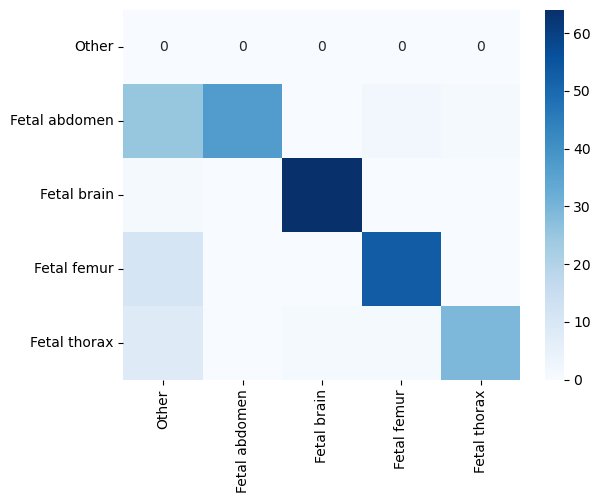

In [38]:
sns.heatmap(cf_matrix,
            annot=True,
            cmap='Blues',
            fmt='g',
            xticklabels=class2idx.keys(),
            yticklabels=class2idx.keys())

#### Compute AUC

In [39]:
from sklearn.metrics import roc_auc_score

In [40]:
def roc_auc_score_multiclass(actual, pred, average = "macro"):
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual]
        new_pred_class = [0 if x in other_class else 1 for x in pred]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [45]:
roc_auc_dict = roc_auc_score_multiclass(targets, preds)
roc_auc_dict

{1: 0.9173992673992675,
 2: 0.8660714285714286,
 3: 0.8905325443786982,
 4: 0.8764208300290774}

In [46]:
avg_auc = 0
for val in roc_auc_dict.values(): 
    avg_auc += val

"{:.2f}".format(avg_auc*100/len(roc_auc_dict))

'88.76'